In [2]:
import pandas as pd
import numpy as np
import datatoolbox as dt
import seaborn as sns
import matplotlib.pyplot as plt
import pyam
import copy
import os

/Users/firzariany/opt/anaconda3/envs/land_use/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


/Users/firzariany/Documents/datashelf_2rawdata/FAO_2019/Emissions_Land_Use_Land_Use_Total_E_All_Data.csv
0 source reader found and added into "datatoolbox.sources".


<IPython.core.display.Javascript object>

This code looks at IMAGE SSP1-19 scenarios for land-use change and emissions / removals.
SSP1-19 data includes carbon sequestraton on managed land (including negative sequestration, i.e. emissions, from degraded forests) and total net land use change emissions. We split the sequestration variable into removals and emissions so that we can assess total emissions and total removals (noting that the C sequestration variable is netted). 

We also look at area changes. Forest and natural forest changes are very similar. A/R shows a sharp increase in forest land, which is also reflected in the total forest land and natural land variables. This mostly seems to come at the expense of natural land, as well as pasture.
Multiplying the total change in forest area by the carbon sequestration per ha values from Cook-Patton gives values that are too high, but this calculation doesn't factor in the time to achieve maximum sequestraton rates and the loss of carbon associated with the land use change.

Indonesia:
Energy crops reach 6.5 Mha by end century. Current land for palm oil is about 15 Mha.
IMAGE sequestration is ...

Brazil
Energy crops reach 63 Mha by end century. Total cropland doubles, pasture reduces by a third.
Current land use for sugarcane (most of which is used for ethanol) is about 9 Mha (Statista)
FAO herbaceous crops: 36 Mha
Wikipedia: cultivated land: 65 Mha. 

In [2]:
%matplotlib inline

In [3]:
path = '/Users/clairefyson/Box/Climate Policy Team/02 - Projects/IKEA NDC 1.5° Pathways 20-22/2- Work Packages/WP3 -  LULUCF Pathways/Workflow/Python_scripts'
os.chdir(path)

In [4]:
scenarios_to_use = ['LOWDEF_BL|IMAGE', 'SSP1-19-SPA1-V17','LOWTOT_19_opf']

In [34]:
# Find IMAGE scenarios (SSP1)
# tab_lu includes all emissions on land (net)
tab_lu = dt.getTable(dt.findp(source="IMAGE*", variable = "Emissions|CO2|Land_Use", scenario = "SSP1-19-SPA1-V17").index[0])

In [6]:
# Find IMAGE scenarios (multiple)
## NOTE that only SSP scenarios have C sequestration
tabs_2020 = dt.getTables(dt.findp(source="IMAGE*", variable = "Emissions|CO2|Land_Use", source_year = '2020').index)
tabs_2020_seq = dt.getTables(dt.findp(source="IMAGE*", variable = "Emissions|CO2|Land_Use|Carbon_Sequestration", source_year = '2020').index)

<ipython-input-23-e69e90e3114f>:2: DeprecationWarning: This method is deprecated and will be removed in future versions. Please use `IamDataFrame.plot()`.
  tabs_2020py.filter(region = 'BRA', scenario = ['LOWDEF_BL', 'SSP1-19-SPA1-V17', 'LOWLI_BL','LOWLI_19_opf']).line_plot()


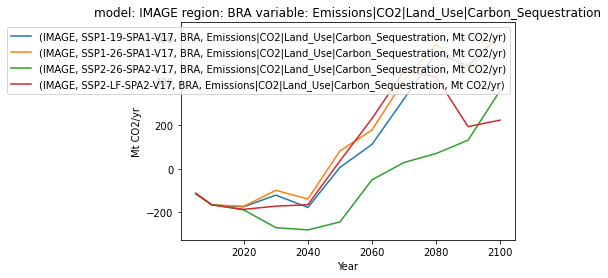

In [23]:
tabs_2020py = tabs_2020_seq.to_pyam()
tabs_2020py.filter(region = 'BRA', scenario = ['LOWDEF_BL', 'SSP1-19-SPA1-V17', 'LOWLI_BL','LOWLI_19_opf']).line_plot()
tabs_2020py.filter(region = 'BRA').plot()

In [30]:
tab_cs_orig = dt.getTable(dt.findp(source="IMAGE*", variable = "Emissions|CO2|Land_Use|Carbon_Sequestration", scenario = "SSP1-19-SPA1-V17").index[0])

In [31]:
tab_ems_forest = copy.deepcopy(tab_cs_orig)
tab_cs = copy.deepcopy(tab_cs_orig)

In [32]:
# sequestration includes emissions from degraded forests, so we remove these "negative removals"
# tab_cs now only includes C sequestration.
# tab_ems_forest includes emissions from degraded forests
for yr in tab_cs_orig.columns:
    for country in tab_cs_orig.index:
        tab_cs.loc[country, yr] = (lambda x: 0 if x <= 0 else x)(tab_cs_orig.loc[country, yr])
        tab_ems_forest.loc[country, yr] = -1*(lambda x: 0 if x > 0 else x)(tab_cs_orig.loc[country, yr])

In [35]:
tab_ems_all = tab_lu + tab_cs #(removes carbon sequestration from the net emissions)
tab_ems_luc = tab_ems_all - tab_ems_forest
test = tab_ems_luc + tab_ems_forest - tab_cs

<AxesSubplot:xlabel='time', ylabel='BRA'>

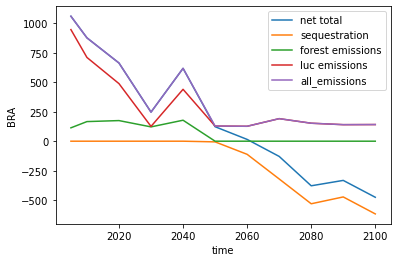

In [36]:
cntry_toplot = 'BRA'
sns.lineplot(x = tab_lu.columns, y = tab_lu.loc[cntry_toplot,:], label = 'net total')
sns.lineplot(x = tab_cs.columns, y = tab_cs.loc[cntry_toplot,:] *-1, label = 'sequestration')
sns.lineplot(x = tab_ems_forest.columns, y = tab_ems_forest.loc[cntry_toplot,:], label = 'forest emissions')
sns.lineplot(x = tab_ems_luc.columns, y = tab_ems_luc.loc[cntry_toplot,:], label = 'luc emissions')
# sns.lineplot(x = test.columns, y = test.loc[cntry_toplot,:], label = 'test')
sns.lineplot(x = tab_ems_all.columns, y = tab_ems_all.loc[cntry_toplot,:], label = 'all_emissions')


In [37]:
df_area = dt.getTables(dt.findp(source="IMAGE*", scenario = "SSP1-19-SPA1-V17", entity = "**Land**").index)
py_area = df_area.to_pyam()

In [4]:
variables_touse = ['Land_Cover|Cropland',
                   'Land_Cover|Pasture',
                   'Land_Cover|Forest'
                   'Land_Cover|Forest|Natural_Forest',
                   'Land_Cover|Forest|Forestry',
                   'Land_Cover|Forest|Harvested_Area'
                   'Land_Cover||Other_Arable_Land',
#                    'Land_Cover|Cropland|excl_bioenergy',
                   'Land_Cover|Cropland|Energy_Crops',
                   'Land_Cover|Built-up_Area',
                   'Land_Cover|Other_Land',
                   'Land_Cover|Other_Natural_Land'
                   'Land_Cover|Total']

variables_touse2 = ['Land_Cover|Cropland',
                   'Land_Cover|Pasture',
                   'Land_Cover|Forest',
                   'Land_Cover|Forest|Natural_Forest',
                   'Land_Cover|Forest|Forestry',
                   'Land_Cover|Forest|Harvested_Area',
                   'Land_Cover||Other_Arable_Land',
#                    'Land_Cover|Cropland|excl_bioenergy',
                   'Land_Cover|Cropland|Energy_Crops',
                   'Land_Cover|Built-up_Area',
                   'Land_Cover|Other_Land',
                   'Land_Cover|Other_Natural_Land',
                   'Land_Cover|Total',
                   'Land_Cover|Cropland|No_Energy',
                   'Land_Cover|Forest|Afforestation_and_Reforestation']

In [5]:
# calculate cropland change excluding bioenergy
tab_crops = dt.getTable(dt.findp(source="IMAGE*", scenario = "SSP1-19-SPA1-V17", variable = 'Land_Cover|Cropland').index[0])
tab_energy = dt.getTable(dt.findp(source="IMAGE*", scenario = "SSP1-19-SPA1-V17", variable = 'Land_Cover|Cropland|Energy_Crops').index[0])
tab_crops_noenergy = tab_crops - tab_energy
tab_crops_noenergy.scenario = 'SSP1-19-SPA1-V17'
tab_crops_noenergy.model = 'IMAGE'
tab_crops_noenergy.variable = 'Land_Cover|Cropland|No_Energy'
# dt.getTable(dt.findp(source="IMAGE*", scenario = "SSP1-19-SPA1-V17", variable = 'Land_Cover|Cropland').index[0])

In [6]:
# tab_crops_noenergy.meta = tab_crops.meta
tab_crops_noenergy.meta = {'ID': 'Land_Cover|Cropland__SSP1-19-SPA1-V17|IMAGE__IMAGE15_2020',
 'unit': 'million ha',
 'category': 'Cropland',
 'creator': 'JH',
 'entity': 'Land_Cover',
 'model': 'IMAGE',
 'pathway': 'SSP1-19-SPA1-V17|IMAGE',
 'scenario': 'SSP1-19-SPA1-V17',
 'source': 'IMAGE15_2020',
 'source_name': 'IMAGE15',
 'source_year': '2020',
 'variable': 'Land_Cover|Cropland|No_Energy'}

In [7]:
df_crops = df_area.filter(variable = 'Land_Cover|Cropland')
df_energy = df_area.filter(variable = 'Land_Cover|Cropland|Energy_Crops')

In [8]:
no_energy_temp = tab_crops_noenergy.to_IamDataFrame().data
areas_df = pd.concat([py_area.data, no_energy_temp], ignore_index = True)

In [9]:
py_area2 = pyam.IamDataFrame(areas_df)

In [10]:
py_area2.variable

['Land_Cover',
 'Land_Cover|Built-up_Area',
 'Land_Cover|Cropland',
 'Land_Cover|Cropland|Cereals',
 'Land_Cover|Cropland|Energy_Crops',
 'Land_Cover|Cropland|Energy_Crops|Irrigated',
 'Land_Cover|Cropland|Irrigated',
 'Land_Cover|Cropland|No_Energy',
 'Land_Cover|Forest',
 'Land_Cover|Forest|Afforestation_and_Reforestation',
 'Land_Cover|Forest|Forestry',
 'Land_Cover|Forest|Forestry|Harvested_Area',
 'Land_Cover|Forest|Natural_Forest',
 'Land_Cover|Other_Arable_Land',
 'Land_Cover|Other_Land',
 'Land_Cover|Other_Natural_Land',
 'Land_Cover|Pasture']

In [11]:
cntry_toplot = 'BRA'
py_area2.filter(region = cntry_toplot, variable = variables_touse2).plot()
plt.legend(bbox_to_anchor=(1, 1))

In [12]:
forests = ['Land_Cover|Forest', 
           'Land_Cover|Forest|Afforestation_and_Reforestation',
           'Land_Cover|Forest|Forestry',
           'Land_Cover|Forest|Forestry|Harvested_Area',
           'Land_Cover|Forest|Natural_Forest']
cntry_toplot = 'BRA'
py_area2.filter(region = cntry_toplot, variable = forests).plot()
plt.legend(bbox_to_anchor=(1, 1))

In [24]:
variable = 'Land_Cover|Forest'
cntry = 'BRA'
country_data = py_area2.filter(region = cntry, variable = variable).data
forest_change = country_data.value.max() - country_data.value.min()

# read in cook-patton data for carbon sequestration per ha
cseq = pd.read_csv('../Data/Cook_Patton_2020/Cook Patton 2020 Nat MOESM2_ESM.csv').set_index('Geography')
list_isos = []
for country in cseq.index:
    iso = dt.getCountryISO(country)
    list_isos.append(iso)
cseq['country'] = list_isos
cseq = cseq.set_index('country')
cntry_cseq = cseq.loc['IDN', 'Mean aboveground rate_MgC_ha_yr'] # in TgC/yr

In [27]:
cntry_cseq = cseq.loc['IDN', 'Mean aboveground rate_MgC_ha_yr'] # in TgC/yr

In [26]:
forest_change

59.68192500000009

In [28]:
cntry_cseq

4.38

In [20]:
# cntry_cseq = cseq.loc['BRA', 'Mean aboveground rate_MgC_ha_yr'] # in TgC/yr

In [23]:
max_removals = cntry_cseq *3.6667 * forest_change # in TgCO2/yr or MtCO2/yr
max_removals 

958.5004290610515

In [19]:
#Using the A/R variable
year = 2100
afforest = py_area2.filter(region = cntry, variable = 'Land_Cover|Forest|Afforestation_and_Reforestation', year = year).data
afforest.value * cntry_cseq * 3.667

0    1048.964918
Name: value, dtype: float64

In [92]:
cntry_seq_model = tab_cs.loc[cntry, 2100]
cntry_seq_model

616.9429819350022

In [95]:
variable = 'Land_Cover|Pasture'
cntry = 'BRA'
country_data = py_area2.filter(region = cntry, variable = variable).data
change = country_data.value.max() - country_data.value.min()
country_data

model          scenario region            variable        unit  year  \
0   IMAGE  SSP1-19-SPA1-V17    BRA  Land_Cover|Pasture  million ha  2005   
1   IMAGE  SSP1-19-SPA1-V17    BRA  Land_Cover|Pasture  million ha  2010   
2   IMAGE  SSP1-19-SPA1-V17    BRA  Land_Cover|Pasture  million ha  2020   
3   IMAGE  SSP1-19-SPA1-V17    BRA  Land_Cover|Pasture  million ha  2030   
4   IMAGE  SSP1-19-SPA1-V17    BRA  Land_Cover|Pasture  million ha  2040   
5   IMAGE  SSP1-19-SPA1-V17    BRA  Land_Cover|Pasture  million ha  2050   
6   IMAGE  SSP1-19-SPA1-V17    BRA  Land_Cover|Pasture  million ha  2060   
7   IMAGE  SSP1-19-SPA1-V17    BRA  Land_Cover|Pasture  million ha  2070   
8   IMAGE  SSP1-19-SPA1-V17    BRA  Land_Cover|Pasture  million ha  2080   
9   IMAGE  SSP1-19-SPA1-V17    BRA  Land_Cover|Pasture  million ha  2090   
10  IMAGE  SSP1-19-SPA1-V17    BRA  Land_Cover|Pasture  million ha  2100   

         value  
0   194.999838  
1   197.739913  
2   186.591000  
3   179.344562  
4   185.247263  
5   185.136850  
6   171.474000  
7   159.138037  
8   148.119500  
9   138.153662  
10  129.006163

In [75]:
tab_cs.loc['INDO']

time
2005      0.000000
2010      0.000000
2020      0.000000
2030      0.000000
2040      0.000000
2050     11.487593
2060    143.493490
2070    184.887379
2080    376.145721
2090    467.388640
2100    453.229199
Name: INDO, dtype: float64